In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import GradientBoostingClassifier

import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data

Adding Symbol: META
entry already exists or no title
Erreur quadratique moyenne (MSE) : 11240.9579


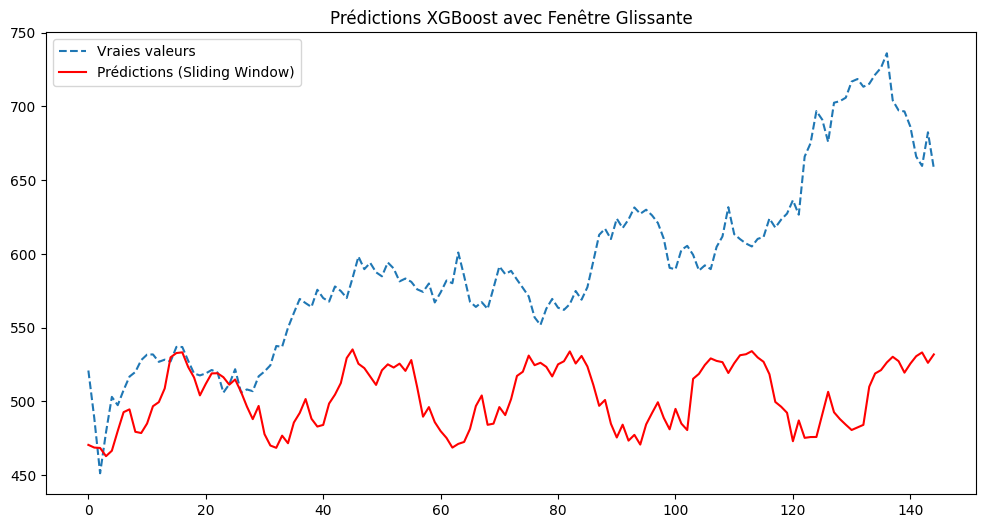

In [40]:
df = get_data('META', granularity='daily')
df.drop(columns=['Title'], inplace=True)
df = df[df['Date'] >= df['Date'].max() - pd.DateOffset(months=36)]
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)
df = df[["Open"]].copy() 

window_size = 30

for lag in range(1, window_size + 1):  
    df[f'lag_{lag}'] = df['Open'].shift(lag)

df.dropna(inplace=True)

params = {
    "objective": "reg:squarederror",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

predictions = []
real_values = df["Open"].iloc[train_size:].values

last_window = df.iloc[train_size - 1, 1:].values.reshape(1, -1)

for i in range(test_size):
    train_data = df.iloc[i : train_size + i]
    
    X_train = train_data.drop(columns=["Open"])
    y_train = train_data["Open"]
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(last_window)[0]
    predictions.append(y_pred)

    last_window = np.roll(last_window, -1)
    last_window[0, -1] = y_pred


mse = mean_squared_error(real_values, predictions)
print(f"Erreur quadratique moyenne (MSE) : {mse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(real_values, label="Vraies valeurs", linestyle='dashed')
plt.plot(predictions, label="Prédictions (Sliding Window)", color='red')
plt.legend()
plt.title("Prédictions XGBoost avec Fenêtre Glissante")
plt.show()
